In [1]:
import datajoint as dj

dj.config["database.host"] = "datajoint-public.internationalbrainlab.org"
dj.config["database.user"] = "ibl-public"
dj.config["database.password"] = "ibl-public" 

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from nma_ibl import reference, subject, action, acquisition, data, behavior, behavior_analyses
from tools import length_last_streak, fetch_mice_by_percentage, search_sequence


[2022-07-26 20:01:02,800][INFO]: Connecting ibl-public@datajoint-public.internationalbrainlab.org:3306
[2022-07-26 20:01:05,651][INFO]: Connected ibl-public@datajoint-public.internationalbrainlab.org:3306


In [3]:
from nma_ibl import reference, subject, action, acquisition, data, behavior, behavior_analyses


In [5]:
def get_streak_data(lab,percentage,features):
  """ Returns streak of rewards and/or punishments before all trials with 50/50 probability, for all mice in chosen lab, with chosen training percentage.

  Parameters
  ----------    
  lab    : input string
  percentage    : input int
  features: input list of signed ints (positive for reward streak length, negative for punish streak length)

  Output
  ------    
  Output :
  2D array with size (features x samples)
  1D array with size samples
  """


  lab_mice_in_training = ((behavior_analyses.SessionTrainingStatus & {'training_status' : 'in_training'}) * subject.SubjectLab & {'lab_name' : lab}) & behavior.TrialSet.Trial
  lab_mice = np.unique(lab_mice_in_training.fetch('subject_uuid'))

  id = lab_mice_in_training.fetch('subject_uuid')
  training_days = np.zeros_like(lab_mice)

  for idx, mouse in enumerate(lab_mice):
    training_days[idx] = len(np.where(id == mouse)[0])

  dictionary = fetch_mice_by_percentage(lab_mice,lab_mice_in_training,percentage)


  X = np.empty((len(features)+1,1))
  
  y = []
  for mouse in lab_mice:
    try:
      for i in range(len(dictionary[mouse])):
        session, contrast_left, contrast_right = ((behavior.TrialSet.Trial & {'subject_uuid' : mouse} & {'trial_stim_prob_left': 0.5}) & {'session_start_time' : dictionary[mouse][i]}).fetch('trial_feedback_type','trial_stim_contrast_left','trial_stim_contrast_right')
        x_0 = contrast_left + contrast_right
        x = x_0

        for feature in features:
          x = np.vstack( (x,search_sequence(session,abs(feature), np.sign(feature) )))
        
        X = np.concatenate((X,x),axis=1)


        y = np.append(y,session)
    except:
      pass
    
  return(X[:,1:],y.astype('float'))

In [25]:
def streak_modelling(X,y):
    x_train, x_test, y_train, y_test = train_test_split(X.T, y, test_size=0.25, random_state=0)
    logisticRegr = LogisticRegression()
    logisticRegr.fit(x_train, y_train)
    coef = logisticRegr.coef_[0]

    y_pred = logisticRegr.predict(x_test)
    training_accuracy = logisticRegr.score(x_train, y_train)
    test_accuracy = logisticRegr.score(x_test, y_test)
    print("Training accuracy:{:.2f}  Test accuracy:{:.2f}".format(training_accuracy*100, test_accuracy*100))
    print("Precision:{:.2f} Recall:{:.2f}".format(precision_score(y_pred, y_test)*100,
                                                recall_score(y_pred, y_test)*100))
    print("Coefficients for logistic regression:")
    print(coef)
    print(confusion_matrix(y_test,y_pred))
    return training_accuracy, test_accuracy

In [7]:
X, y = get_streak_data("mainenlab", 50, [2,3,-2,-3])
print(X.shape, y.shape)
# streak_modelling(X,y)

(5, 24909) (24909,)


In [8]:
column_names=['contrast','pos_streak_2','pos_streak_3','neg_streak_2','neg_streak_3']
df=pd.DataFrame(data=X.T, columns=column_names)
df.corr()

,contrast,pos_streak_2,pos_streak_3,neg_streak_2,neg_streak_3
contrast,1.000000,0.031687,0.020391,-0.005621,0.018082
pos_streak_2,0.031687,1.000000,0.765443,-0.363305,-0.230800
pos_streak_3,0.020391,0.765443,1.000000,-0.278089,-0.176664
neg_streak_2,-0.005621,-0.363305,-0.278089,1.000000,0.635280
neg_streak_3,0.018082,-0.230800,-0.176664,0.635280,1.000000


In [7]:
pc=np.arange(10,100,10)
train=[]
test=[]
for percentage in pc:
    print("%_trained_mice_considered:{}".format(percentage))
    data_X, data_y = get_streak_data("mainenlab", percentage, [2,3,-2,-3])
    train_acc, test_acc = streak_modelling(data_X,data_y)
    train.append(train_acc)
    test.append(test_acc)
    print("-------------------------------------------------------------------\n")

[2022-07-23 00:49:52,453][WARNING]: MySQL server has gone away. Reconnecting to the server.


%_trained_mice_considered:10
Training accuracy:76.52  Test accuracy:75.75
Precision:72.82 Recall:74.70
-------------------------------------------------------------------

%_trained_mice_considered:20
Training accuracy:78.13  Test accuracy:77.02
Precision:76.13 Recall:75.39
-------------------------------------------------------------------

%_trained_mice_considered:30
Training accuracy:78.07  Test accuracy:78.44
Precision:60.81 Recall:100.00
-------------------------------------------------------------------

%_trained_mice_considered:40
Training accuracy:80.95  Test accuracy:82.08
Precision:85.20 Recall:87.43
-------------------------------------------------------------------

%_trained_mice_considered:50
Training accuracy:81.56  Test accuracy:81.71
Precision:84.36 Recall:88.16
-------------------------------------------------------------------

%_trained_mice_considered:60
Training accuracy:84.41  Test accuracy:83.80
Precision:85.90 Recall:91.30
------------------------------------

<AxesSubplot:xlabel='%_trained'>

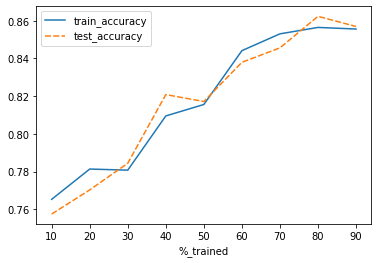

In [8]:
data_for_acc_vs_percentage_trained = {"%_trained":pc,
                                      "train_accuracy": train,
                                      "test_accuracy": test}
df = pd.DataFrame(data_for_acc_vs_percentage_trained).set_index("%_trained")
# df.head(10)
sns.lineplot(data=df)

In [95]:
from tools import length_last_streak
lab="mainenlab"
percentage=50

In [16]:
def get_streak_length(lab, percentage):
  lab_mice_in_training = behavior_analyses.SessionTrainingStatus & 'training_status = "in_training" ' & (subject.SubjectLab & 'lab_name = "{}"'.format(lab)) 
  lab_mice = np.unique(lab_mice_in_training.fetch('subject_uuid'))

  id = lab_mice_in_training.fetch('subject_uuid')
  training_days = np.zeros_like(lab_mice)

  for idx, mouse in enumerate(lab_mice):
    training_days[idx] = len(np.where(id == mouse)[0])

  dictionary = fetch_mice_by_percentage(lab_mice,lab_mice_in_training,percentage)
  # print(dictionary)

  X_0=[]
  X_1=[]
  X_2=[]

  y = []
  for mouse in lab_mice:
    try:
      for i in range(len(dictionary[mouse])):
        session, contrast_left, contrast_right = ((behavior.TrialSet.Trial & {'subject_uuid' : mouse} & {'trial_stim_prob_left': 0.5}) & {'session_start_time' : dictionary[mouse][i]}).fetch('trial_feedback_type',
        'trial_stim_contrast_left',
        'trial_stim_contrast_right')
        
        x_0 = contrast_left + contrast_right
        x_pos = [length_last_streak(session,j,1) for j in range(len(session))]
        x_neg = [length_last_streak(session,j,-1) for j in range(len(session))]

        X_0 = np.append(X_0,x_0)
        X_1 = np.append(X_1,x_pos)
        X_2 = np.append(X_2,x_neg)

        y = np.append(y,session)
    except:
      pass
  X = np.vstack((X_0,X_1,X_2))
  X = X.astype("float")
  y = y.astype("float")

  return (X, y)

In [17]:
X,y = get_streak_length("mainenlab", 10)

In [18]:
train_acc, test_acc = streak_modelling(X,y)

(3, 24705) (24705,)


In [26]:
pc=np.arange(10,100,10)
train=[]
test=[]
for percentage in pc:
    print("%_trained_mice_considered:{}".format(percentage))
    data_X, data_y = get_streak_length("mainenlab", percentage)
    train_acc, test_acc = streak_modelling(data_X,data_y)
    train.append(train_acc)
    test.append(test_acc)
    print("----")

%_trained_mice_considered:10
Training accuracy:53.78  Test accuracy:52.17
Precision:0.00 Recall:0.00
----
%_trained_mice_considered:20


/Users/shayan/opt/anaconda3/envs/rl/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Training accuracy:54.11  Test accuracy:55.58
Precision:56.88 Recall:55.29
----
%_trained_mice_considered:30
Training accuracy:60.65  Test accuracy:60.15
Precision:92.04 Recall:60.82
----
%_trained_mice_considered:40
Training accuracy:66.34  Test accuracy:66.33
Precision:98.22 Recall:66.55
----
%_trained_mice_considered:50
Training accuracy:70.36  Test accuracy:70.81
Precision:98.81 Recall:71.14
----
%_trained_mice_considered:60
Training accuracy:73.87  Test accuracy:73.87
Precision:99.09 Recall:74.12
----
%_trained_mice_considered:70
Training accuracy:76.84  Test accuracy:76.42
Precision:99.70 Recall:76.53
----
%_trained_mice_considered:80
Training accuracy:76.22  Test accuracy:75.98
Precision:99.79 Recall:76.07
----
%_trained_mice_considered:90
Training accuracy:75.53  Test accuracy:75.61
Precision:99.72 Recall:75.70
----


<AxesSubplot:xlabel='%_trained'>

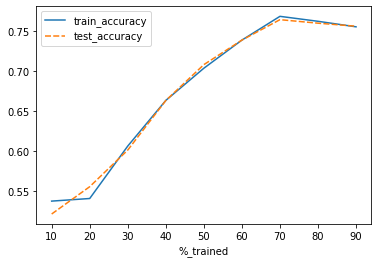

In [24]:
data_for_acc_vs_percentage_trained = {"%_trained":pc,
                                      "train_accuracy": train,
                                      "test_accuracy": test}
df = pd.DataFrame(data_for_acc_vs_percentage_trained).set_index("%_trained")
# df.head(10)
sns.lineplot(data=df)